In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from utils.path import (
    TRAJ_DIR,
    RESULT_DIR,
    RAW_DIR,
    GROUND_TRAJECTORY_FILENAME,
    EXITED_TRAJECTORY_FILENAME,
    IMAGES_DIR
)

from rdp import rdp as rdp_classic
from traj_toolbox.cy_tools import rdp_recursive as cy_rdp


In [3]:
IF = -50e6
first_idx = 500
last_idx = 2000
t = np.arange(0, 8e-6, 2e-9)[first_idx:last_idx]
eps = 0  # if you want to reduse dimention of trajectory - increase epsilon value


## LOAD DATA


In [4]:
%%time
with open(f'{RAW_DIR}SingleShot_raw_Ie_part1_(2022-03-17).pkl', 'rb') as f:
    Ie_part1 = pickle.load(f) # first part of X-axis values from exited-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Ie_part2_(2022-03-17).pkl', 'rb') as f:
    Ie_part2 = pickle.load(f) # second part of X-axis values from exited-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Ig_part1_(2022-03-17).pkl', 'rb') as f:
    Ig_part1 = pickle.load(f) # first part of X-axis values from ground-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Ig_part2_(2022-03-17).pkl', 'rb') as f:
    Ig_part2 = pickle.load(f) # second part of X-axis values from ground-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Qe_part1_(2022-03-17).pkl', 'rb') as f:
    Qe_part1 = pickle.load(f) # first part of Y-axis values from exited-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Qe_part2_(2022-03-17).pkl', 'rb') as f:
    Qe_part2 = pickle.load(f) # second part of Y-axis values from exited-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Qg_part1_(2022-03-17).pkl', 'rb') as f:
    Qg_part1 = pickle.load(f) # first part of Y-axis values from ground-state qubit data

with open(f'{RAW_DIR}SingleShot_raw_Qg_part2_(2022-03-17).pkl', 'rb') as f:
    Qg_part2 = pickle.load(f) # second part of Y-axis values from ground-state qubit data

Ie = np.array(Ie_part1 + Ie_part2, dtype='float')
del Ie_part1, Ie_part2

Ig = np.array(Ig_part1 + Ig_part2, dtype='float')
del Ig_part1, Ig_part2

Qe = np.array(Qe_part1 + Qe_part2, dtype='float')
del Qe_part1, Qe_part2

Qg = np.array(Qg_part1 + Qg_part2, dtype='float')
del Qg_part1, Qg_part2

CPU times: user 2.76 s, sys: 7.65 s, total: 10.4 s
Wall time: 13.7 s


## Exponential rotation


In [5]:
def exponential_rotation(I, Q, IF, t, direction):
    if direction == "clockwise":
        output = (I + 1j * Q) * np.exp(-1j * 2 * np.pi * IF * t)
    else:
        output = (I + 1j * Q) * np.exp(1j * 2 * np.pi * IF * t)
    return output.real, output.imag


In [6]:
E = []
G = []

length = len(Ie)

for i in range(length):
    Ig_i = Ie[i][first_idx:last_idx]
    Qg_i = Ig[i][first_idx:last_idx]
    Ie_i = Qe[i][first_idx:last_idx]
    Qe_i = Qg[i][first_idx:last_idx]

    Ig_i -= Ig_i.mean()
    Qg_i -= Qg_i.mean()
    Ie_i -= Ie_i.mean()
    Qe_i -= Qe_i.mean()

    Ig_rotate, Qg_rotate = exponential_rotation(Ig_i, Qg_i, IF, t, "1")
    Ie_rotate, Qe_rotate = exponential_rotation(Ie_i, Qe_i, IF, t, "1")

    G_stack = np.column_stack([Ig_rotate, Qg_rotate])
    E_stack = np.column_stack([Ie_rotate, Qe_rotate])

    G.append(G_stack)
    E.append(E_stack)

rand_idx = np.random.randint(0, len(E) - 1)


## Reducing the dimensionality via Ramer Douglas Peucker algorithm (if needed)


In [7]:
%%time
if eps > 0:
    G_reduce_size = [cy_rdp.RDP(G[i], epsilon=eps) for i in range(len(G))]
    E_reduce_size = [cy_rdp.RDP(E[i], epsilon=eps) for i in range(len(E))]

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs


In [8]:
if eps > 0:
    rdp_mask = rdp_classic(G[rand_idx], epsilon=eps, return_mask=True)

    plt.plot(
        t,
        G[rand_idx][:, 0],
        color="lightslategrey",
        label=f"original signal, len={len(G[rand_idx])}",
    )
    plt.plot(
        t[rdp_mask],
        G_reduce_size[rand_idx][:, 0],
        color="darkred",
        markersize=1,
        alpha=1,
        linestyle="--",
        label=f"eps={eps}, len={len(t[rdp_mask])}",
    )
    plt.xlim([1e-6, 1.5e-6])
    plt.xlabel("t, s", size=13)
    plt.ylabel(r"$I_{GROUND}$", size=13)
    plt.legend()
    plt.savefig(f"I_ground_eps_{str(eps)}.png", dpi=500)


## Plotting random exited ang ground state trajectory


dimention of 24377 trajectory is  (1500, 2)


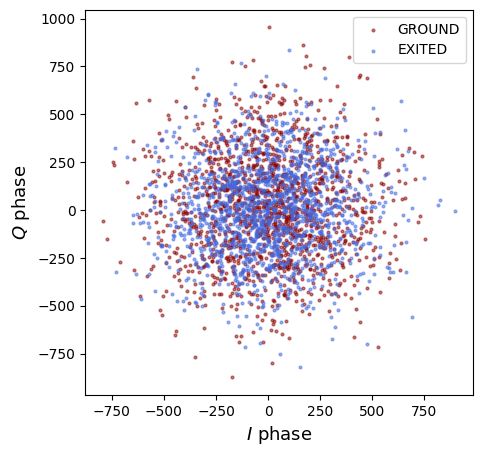

In [19]:
print(f"dimention of {rand_idx} trajectory is ", G[rand_idx].shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(
    G[rand_idx][:, 0], G[rand_idx][:, 1], color="darkred", alpha=0.5, label="GROUND", s=4
)
plt.scatter(
    E[rand_idx][:, 0], E[rand_idx][:, 1], color="royalblue", alpha=0.5, label="EXITED", s=4
)
plt.xlabel(r"$I$ phase", size=13)
plt.ylabel(r"$Q$ phase", size=13)
plt.legend()
plt.savefig(f'{IMAGES_DIR}random_ground_exited.png', dpi=250)

## Save data


In [10]:
if eps > 0:
    np.save(TRAJ_DIR + GROUND_TRAJECTORY_FILENAME, G_reduce_size)
    np.save(TRAJ_DIR + EXITED_TRAJECTORY_FILENAME, E_reduce_size)
else:
    np.save(TRAJ_DIR + GROUND_TRAJECTORY_FILENAME, G)
    np.save(TRAJ_DIR + EXITED_TRAJECTORY_FILENAME, E)
